# Image Experiments -- Granularity and Occlusion Colour #

The experiments are executed by calling the `experiments.py` script.
The first parameter is the type of experiments, `img` for all images in a
directory or `img_rand` for a random sample of 150 images (note that some of
the images may not be segmented into the specified number of super-pixels so
it is always better to request more images);
the second parameter is a path to a directory with images;
the third is the number of requested segments, one of 5, 10, 15, 20, 30 or 40.
For example:
```bash
./experiments.py img /mnt/data/shared/ks1591/datasets/imagenet/imagenet_val 5
```

To process the results execute this notebook -- remember to set `data_path`
to the correct pickle file.

In [1]:
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = 'img/intrep_5.pickle'

In [3]:
with open(data_path, 'rb') as f:
    exp_data = pickle.load(f)
exp_data_segments = int(os.path.basename(data_path)[7:][:-7])

In [4]:
# Extract top prediction
exp_by_colour = {}

for fname in exp_data:
    pred = exp_data[fname][0]
    pred_idx = np.argmax(pred)
    pred_proba = pred[pred_idx]

    exp = exp_data[fname][1]
    if exp_data[fname][1] is None:
        continue

    for colour in exp:
        if colour not in exp_by_colour:
            exp_by_colour[colour] = {}

        for occlusion_size, occlusion in enumerate(exp[colour]):
            if occlusion_size not in exp_by_colour[colour]:
                exp_by_colour[colour][occlusion_size] = []

            occlusion_proba_diff = occlusion[:, pred_idx] - pred_proba
            exp_by_colour[colour][occlusion_size].append(occlusion_proba_diff)

            if occlusion_size == 0:
                assert np.allclose(occlusion_proba_diff, 0, atol=1e-5)

In [5]:
# Restructure and compute MSE
plot_by_colour = {}

for colour in exp_by_colour:
    mean, std = [], []
    occlusion_sizes = sorted(list(exp_by_colour[colour].keys()))
    for occlusion_size in occlusion_sizes:
        all_images = np.concatenate(exp_by_colour[colour][occlusion_size])

        all_images_sqr = np.square(all_images)

        all_images_mean = np.mean(all_images_sqr)
        all_images_std = np.std(all_images_sqr)
        mean.append(all_images_mean)
        std.append(all_images_std)

    assert colour not in plot_by_colour
    plot_by_colour[colour] = {'mean': mean, 'std': std}

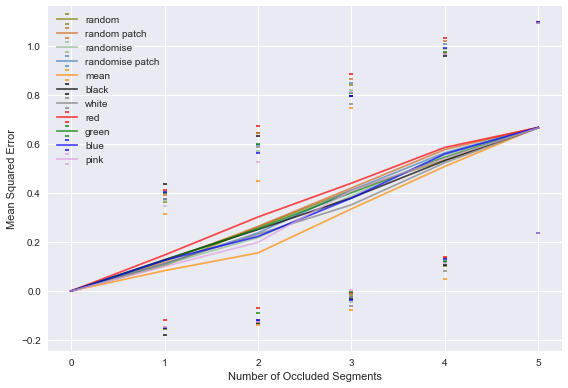

In [6]:
# NBVAL_IGNORE_OUTPUT
plt.style.use('seaborn')
fig = plt.figure()

args = dict(
    solid_capstyle='projecting',
    capsize=2,
    capthick=2,
    alpha=0.7,
    # elinewidth=1e-32
)

# https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
colours = [
    'random', 'random-patch', 'randomise', 'randomise-patch', 'mean',
    'black', 'white', 'red', 'green', 'blue', 'pink']
plot_colours = [
    'olive', 'chocolate', 'darkseagreen', 'steelblue', 'darkorange',
    'k', 'grey', 'r', 'g', 'b', 'plum']

x_ticks = list(range(0, exp_data_segments + 1))
x_step = 1 if exp_data_segments < 30 else 2

for colour, marker_colour in zip(colours, plot_colours):
    markers, caps, bars = plt.errorbar(
        x_ticks,
        plot_by_colour[colour]['mean'],
        yerr=plot_by_colour[colour]['std'],
        label=colour.replace('-', ' '),
        c=marker_colour, 
        **args)
    [bar.set_alpha(0) for bar in bars]
    [bar.remove() for bar in bars]


plt.ylabel('Mean Squared Error')
plt.xlabel('Number of Occluded Segments')

plt.xticks(np.arange(0, exp_data_segments + 1, step=x_step))

plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig(f'_figures/intrep_img_{exp_data_segments}.pdf',
            transparent=False, dpi=300, bbox_inches='tight')